# Neural Radiance Fields (NeRF) in Keras

---

Written by Jonathan Zamora

**Paper**: [NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis](https://arxiv.org/pdf/2003.08934.pdf)

**Implementation Reference**: [3D Volumetric Rendering with NeRF](https://keras.io/examples/vision/nerf/)

## Step 1: Import Relevant Packages and Initialize Global Variables

In [10]:
# Tensorflow dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# General dependencies
import os
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Global variable initializations
tf.random.set_seed(0)
auto = tf.data.AUTOTUNE
batch_size = 5
num_samples = 32
pos_encode_dims = 16
epochs = 200

## Step 2: Download + Load Data

![Multiple Camera Angles](https://i.imgur.com/FLsi2is.png)

![3D World to 2D Image Mapping via Camera](https://www.mathworks.com/help/vision/ug/calibration_coordinate_blocks.png)

Consider the following equation:

$$
x = PX
$$

where $x$ is the 2D Image Point, $X$ is the 3D World Point, and $P$ is the Camera Matrix. In particular, $P$ is a $3x4$ matrix that maps the real world object onto an image plane.

$$
\begin{bmatrix}
X \\
Y \\
Z
\end{bmatrix} =
\begin{bmatrix}
p_1 & p_2 & p_3 & p_4 \\
p_5 & p_6 & p_7 & p_8 \\
p_9 & p_{10} & p_{11} & p_{12}
\end{bmatrix}
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}
$$

The camera matrix is an affine transformation matrix that is concatenated with a $3x1$ column vector composed of `[image, height, image width, focal length]` to produce the pose matrix.

The pose matrix is $3x5$, and the first $3x3$ block is in the camera's POV. The axes are `[down, right, backwards]` or `[-y, x, z]` where the camera is facing towards `-z`.

The COLMAP frame is `[right, down, forwards]` or `[x, -y, -z]`.

12738560/12727482 [==============================] - 0s 0us/step


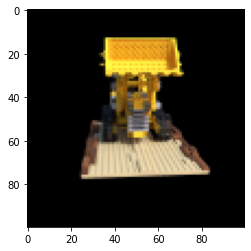

In [2]:
file_name = "tiny_nerf_data.npz"
data_url = "https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz"

if not os.path.exists(file_name):
    data = keras.utils.get_file(fname=file_name, origin=data_url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = im_shape
(poses, focal) = (data["poses"], data["focal"])

# plot random image from the dataset
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

## Step 3: Construct Data Pipeline

We need to understand how to map from 2D Image to 3D Scene now. Here, we consider Volumetric Rendering with Ray Casting and Tracing, common techniques in Computer Graphics.

Suppose we have an image with $N$ pixels. We shoot a **ray** through each pixel and **sample some points** on the ray. A ray is commonly parameterized by the equation $$r(t) = o + td$$ where $t$ is the parameter, $o$ is the origin, and $d$ is the unit directional vector as shown in the figure below.

![ray visualization](https://i.imgur.com/ywrqlzt.gif)

In the next figure, we consider a ray and sample some random points on the ray. The sampled points each have a **unique location** $(x, y, z)$, and the ray has a **viewing angle** $(theta, phi)$. We consider the viewing angle as something interesting since we can shoot a ray through a single pixel from many unique viewing angles. Something else to consider is that **noise** is added to the sampling process. The uniform noise is added to each sample so the samples correspond to a **continuous distribution**. In the below figure, the *blue points* are the **evenly distributed samples** and the *white points* $(t_1, t_2, t_3)$ are **randomly placed** between the samples.

![sampling points from a ray](https://i.imgur.com/r9TS2wv.gif)

The entire sampling process is shown in 3D below. Here, we see the rays coming out of the white image, meaning that each pixel will have its corresponding rays and each ray will be sampled at distinct points.

![shooting rays from all pixels of image in 3D](https://i.imgur.com/hr4D2g2.gif)

The sampled points are **input** to the NeRF model, and the model is then asked to **predict RGB color** and **volume density** at that point.

![NeRF Pipeline](https://i.imgur.com/HHb6tlQ.png)

In [3]:
def encode_position(x):
    '''
    Encodes the position into its corresponding fourier feature

    args:
        x: input coordinate
    
    returns:
        fourier features tensors of the position
    '''

    positions = [x]

    for i in range(pos_encode_dims):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0 ** i * x))
    
    return tf.concat(positions, axis=-1)

def get_rays(height, width, focal, pose):
    '''
    Computes the origin point and direction vector of rays

    args:
        height: height of the image
        width: width of the image
        focal: focal length between the images and the camera
        pose: pose matrix of the camera
    
    returns:
        tuple of origin point and direction vector for rays
    '''

    # build meshgrid for the rays
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy"
    )

    # normalize the x-axis and y-axis coordinates
    transformed_i = (i - width * 0.5) / focal
    transformed_j = (j - height * 0.5) / focal

    # create the direction unit vectors
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # get the camera matrix
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # get origins and directions for the rays
    transformed_directions = directions[..., None, :]
    camera_directions = transformed_directions * camera_matrix
    ray_directions = tf.reduce_sum(camera_directions, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # return the origins and directions
    return (ray_origins, ray_directions)

def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    '''
    Renders the rays and flattens them

    args:
        ray_origins: the origin points for rays
        ray_directions: the direction unit vectors for the rays
        near: the near bound of the volumetric scene
        far: the far bound of the volumetric scene
        num_samples: number of sample points in a ray
        rand: choice for randomizing the sampling strategy
    
    returns:
        tuple of flattened rays and sample points on each ray
    '''

    # compute 3D query points
    # equation: r(t) = o + td -> Building the "t" here
    t_vals = tf.linspace(near, far, num_samples)

    if rand:
        # inject uniform noise into sample space to make the sampling continuous
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals += noise
    
    # equation: r(t) = o + td -> Building the "r" here
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None])
    
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    
    return (rays_flat, t_vals)

def map_fn(pose):
    '''
    Maps individual pose to flattened rays and sample points

    args:
        pose: the pose matrix of the camera
    
    returns:
        tuple of flattened rays and sample points corresponding to the camera pose
    '''

    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=num_samples,
        rand=True
    )
    return (rays_flat, t_vals)

# create the training split
split_index = int(num_images * 0.8)

# split the images into training and validation
train_images = images[:split_index]
val_images = images[split_index:]

# split the poses into training and validation
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# make the training pipeline
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=auto)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(batch_size)
    .batch(batch_size, drop_remainder=True, num_parallel_calls=auto)
    .prefetch(auto)
)

# make the validation pipeline
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=auto)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(batch_size)
    .batch(batch_size, drop_remainder=True, num_parallel_calls=auto)
    .prefetch(auto)
)

## Step 4: Create NeRF Model

NeRF is a Multi-Layer Perceptron (MLP) with ReLU as its non-linearity.

From the paper:

> We encourage the representation to be multiview-consistent by restricting the network to predict the volume density sigma as a function of only the location `x`, while allowing the RGB color `c` to be predicted as a function of both location and viewing direction. To accomplish this, the MLP first processes the input 3D coordinate `x` with 8 fully-connected layers (using ReLU activations and 256 channels per layer), and outpus sigma and a 256-dimensional feature vector. This feature vector is then concatenated with the camera ray's viewing direction and passed to one additional fully-connected layer (using a ReLU activation and 128 channels) that output the view-dependent RGB color.

This implementation in Keras uses 64 Dense units instead of 256 as mentioned in the paper.

In [8]:
def get_nerf_model(num_layers, num_pos):
    '''
    Generates the NeRF neural network

    args:
        num_layers: the number of MLP layers
        num_pos: the number of dimensions of positional encoding
    
    returns:
        the tf.keras model
    '''

    inputs = keras.Input(shape=(num_pos, 2 * 3 * pos_encode_dims + 3))

    x = inputs

    for i in range(num_layers):
        x = layers.Dense(units=128, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # inject residual connection
            x = layers.concatenate([x, inputs], axis=-1)
    
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    '''
    Generates the RGB image and Depth Map from Model Prediction

    args:
        model: The MLP model that is trained to predict the rgb and volume density
               of the volumetric scene
        rays_flat: The flattened rays that serve as the input to the NeRF model
        t_vals: The sample points for the rays
        rand: Choice to randomize the sampling strategy
        train: Whether the model is in the training or testing phase
    
    returns:
        tuple of rgb image and depth map
    '''

    # get the predictions from the NeRF model and reshape it
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    
    predictions = tf.reshape(predictions, shape=(batch_size, H, W, num_samples, 4))

    # slice the predictions into rgb and sigma
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # get the distance of adjacent intervals
    delta = t_vals[..., 1:] - t_vals[..., :-1]

    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(batch_size, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(batch_size, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])
    
    # get transmittance
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    
    return (rgb, depth_map)

## Step 5: Train the NeRF model

In [ ]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model
    
    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")
    
    def train_step(self, inputs):
        # get the images and the rays
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # get the predictions from the model
            rgb, _ = render_rgb_depth(
                model=self.nerf_model,
                rays_flat = rays_flat,
                t_vals = t_vals,
                rand=True
            )
            loss = self.loss_fn(images, rgb)
        
        # get the trainable variables
        trainable_variables = self.nerf_model.trainable_variables

        # get the gradients of the trainable variables with respect to the loss
        gradients = tape.gradient(loss, trainable_variables)

        # apply the grads and optimize the model
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # get the PSNR of the reconstructed images and the source images
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}
    
    def test_step(self, inputs):
        # get the images and the rays
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # get the predictions from the model
        rgb, _ = render_rgb_depth(
            model=self.nerf_model,
            rays_flat=rays_flat,
            t_vals=t_vals,
            rand=True
        )

        loss = self.loss_fn(images, rgb)

        # get the PSNR of the reconstructed images and the source images
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)

        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}
    
    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]

test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []

class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False
        )

        # plot the RGB Image, Depth Map, Loss Plot
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.preprocessing.image.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.preprocessing.image.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, epochs+1, 20.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()

num_pos = H * W * num_samples
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError())

# Create a directory to save the images during training
if not os.path.exists("images"):
    os.makedirs("images")

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[TrainMonitor()],
    steps_per_epoch=split_index // batch_size
)

def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)

create_gif("images/*.png", "training.gif")

## Step 6: Inference

During inference, we use our model to build novel views of the scene. In this example, the model was given 106 views of the scene in the training step. The training images cannot contain every angle of the scene. A trained model can represent the entire 3D scene with a sparse set of training images.

Here, we provide different poses to the model and ask for it to give us the 2D image corresponding to that camera view. If we infer the model for all the 360-degree views, it should provide an overview of the entire scenery from all around.

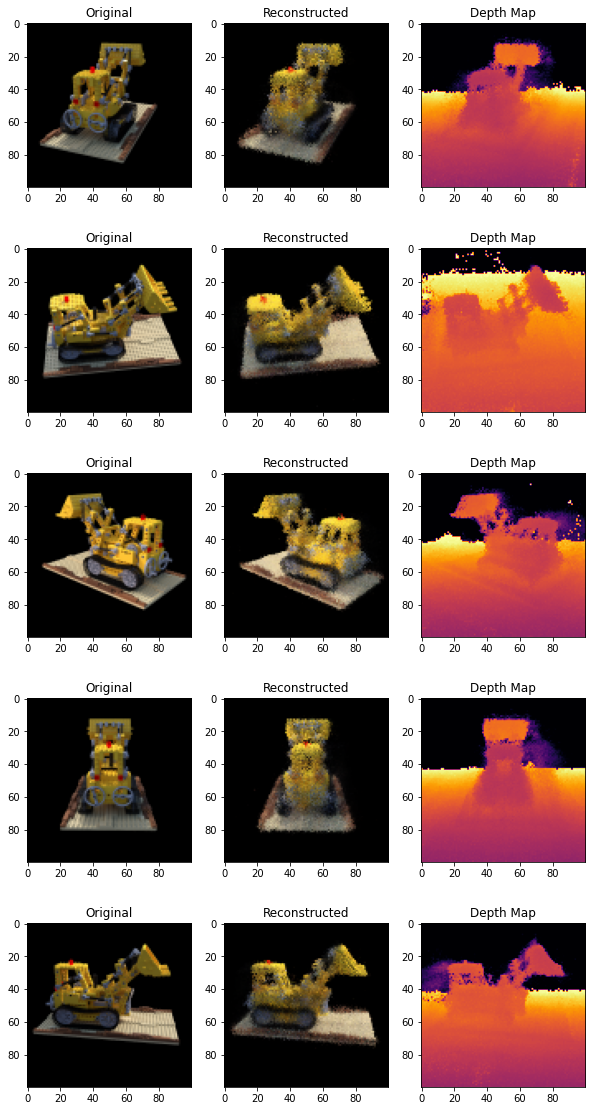

In [13]:
# get the trained NeRF model and run inference
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False
)

# create subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, orig_img, recon_img, depth_map in zip(axes, test_imgs, test_recons_images, depth_maps):
    ax[0].imshow(keras.preprocessing.image.array_to_img(orig_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.preprocessing.image.array_to_img(recon_img))
    ax[1].set_title("Reconstructed")
    
    ax[2].imshow(keras.preprocessing.image.array_to_img(depth_map[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")

## Step 7: Render 3D Scene

We finally synthesize novel 3D views and stitch them all together to render a 360-degree view video.

In [17]:
def get_translation_t(t):
    '''
    Get the translation matrix for movement in t
    '''

    matrix = [
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, t],
              [0, 0, 0, 1]
    ]

    return tf.convert_to_tensor(matrix, dtype=tf.float32)

def get_rotation_phi(phi):
    '''
    Get the rotation matrix for movement in phi
    '''

    matrix = [
              [1, 0, 0, 0],
              [0, tf.cos(phi), -tf.sin(phi), 0],
              [0, tf.sin(phi), tf.cos(phi), 0],
              [0, 0, 0, 1]
    ]

    return tf.convert_to_tensor(matrix, dtype=tf.float32)

def get_rotation_theta(theta):
    '''
    Get the rotation matrix for movement in theta
    '''

    matrix = [
              [tf.cos(theta), 0, -tf.sin(theta), 0],
              [0, 1, 0, 0],
              [tf.sin(theta), 0, tf.cos(theta), 0],
              [0, 0, 0, 1]
    ]

    return tf.convert_to_tensor(matrix, dtype=tf.float32)

def pose_spherical(theta, phi, t):
    '''
    Get the camera to world matrix for the corresponding theta, phi, and t
    '''

    cam2world = get_translation_t(t)
    cam2world = get_rotation_phi(phi / 180.0 * np.pi) @ cam2world
    cam2world = get_rotation_theta(theta / 180.0 * np.pi) @ cam2world
    cam2world = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ cam2world
    return cam2world

rgb_frames = []
batch_flat = []
batch_t = []

# iterate over different theta values and generate scenes

for idx, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    # get the cam2world matrix
    cam2world = pose_spherical(theta, -30.0, 4.0)

    ray_origins, ray_directions = get_rays(H, W, focal, cam2world)
    rays_flat, t_vals = render_flat_rays(ray_origins, ray_directions, near=2.0, 
                                         far=6.0, num_samples=num_samples, rand=False)
    
    if idx % batch_size == 0 and idx > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(nerf_model, batched_flat, batched_t, rand=False, train=False)

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames += temp_rgb

    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)

120it [00:19,  6.01it/s]


## Conclusion

You are now finished with your minimal implementation of NeRF